In [114]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
from plot_functions import adjustAxeProperties
%matplotlib inline
matplotlib.style.use('ggplot')

In [51]:
from plot_functions import adjustAxeProperties

In [6]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [7]:
import keras as k

Using TensorFlow backend.


In [27]:
p_to_file = os.path.expanduser('~/ml_datasets/kaggle_credit_card_fraud_detection/creditcard.csv')
data = pd.read_csv(p_to_file, header=0)

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
data.shape

(284807, 31)

In [11]:
data.isnull().values.any()

False

In [12]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [13]:
normal_data = data[data['Class'] == 1]
fraud_data = data[data['Class'] == 0]

### Plot the distribution of amounts, broken out by normal and fraudulent 

Text(0, 0.5, 'Frequency')

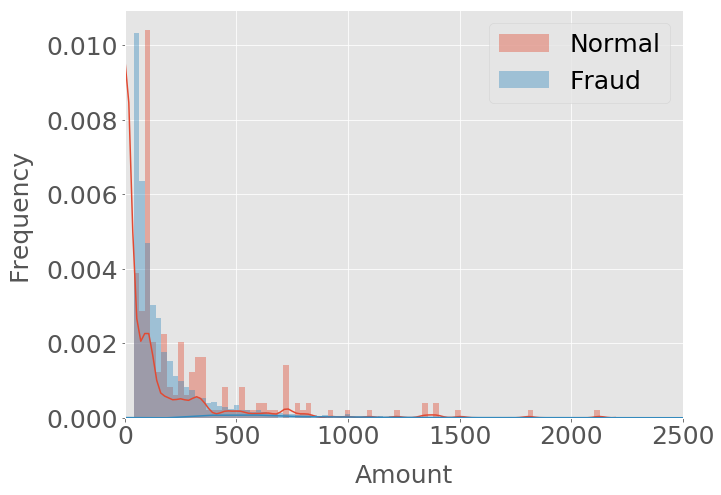

In [14]:
FONTSIZE = 25
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 7.5))
bins = np.linspace(40, 2500, 100)
ax = sbn.distplot(normal_data['Amount'], norm_hist=True, ax=ax, bins=bins, label='Normal')
ax = sbn.distplot(fraud_data['Amount'], norm_hist=True, ax=ax, bins=bins, label='Fraud')
ax.set_xlim(0, 2500)
ax.legend(loc='best', fontsize=FONTSIZE)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.set_xlabel('Amount', labelpad=15, fontsize=FONTSIZE)
ax.set_ylabel('Frequency', labelpad=15, fontsize=FONTSIZE)


In [28]:
y = data.pop('Class')
X_tmp, X_test, y_tmp, y_test = train_test_split(data, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.15)

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_normed = scaler.transform(X_train)
X_val_normed = scaler.transform(X_val)
X_test_normed = scaler.transform(X_test)

In [80]:
X_train_normed_normal = X_train_normed[y_train == 0]
X_train_normed_fraudulent = X_train_normed[y_train == 1]

X_val_normed_normal = X_val_normed[y_val == 0]
X_val_normed_fraudulent = X_val_normed[y_val == 1]

X_test_normed_normal = X_test_normed[y_test == 0]
X_test_normed_fraudulent = X_test_normed[y_test == 1]


In [81]:
input_dim = X_train_normed.shape[-1]
hidden_dim = 16

num_epochs = 64
learning_rate = 1e-5
regularization = 1e-3
batch_size = 128

autoencoder = k.models.Sequential()
autoencoder.add(
    k.layers.Dense(
        hidden_dim, 
        kernel_regularizer=k.regularizers.l2(regularization),
        activation='relu'
    )
)
autoencoder.add(k.layers.Dense(input_dim))

autoencoder.compile(
    optimizer=k.optimizers.RMSprop(lr=learning_rate),
    loss='mse',
    metrics=['mse']
)

In [82]:
history = autoencoder.fit(
    X_train_normed_normal,
    X_train_normed_normal,
    validation_data=(X_val_normed, X_val_normed),
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=False
)

In [83]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(
                factor * prev + (1 - factor) * point
            )
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mse_train = history.history['loss']
smoothed_mse_val = history.history['val_loss']

In [84]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

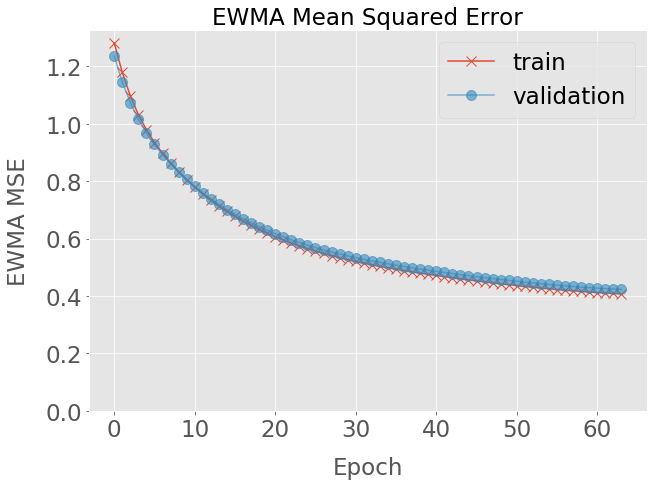

In [85]:
FONTSIZE = 23
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 7))

ax.plot(range(len(smoothed_mse_train)), smoothed_mse_train, marker='x', markersize=10, label='train')
ax.plot(range(len(smoothed_mse_val)), smoothed_mse_val, marker='o', markersize=10, alpha=0.6, label='validation')
ax.set_xlabel('Epoch', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('EWMA MSE', fontsize=FONTSIZE, labelpad=15)
ax.set_ylim(0)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE)
_ = ax.set_title('EWMA Mean Squared Error', fontsize=FONTSIZE)

In [87]:
train_predictions = autoencoder.predict(X_train_normed)
train_error = np.mean(np.power(X_train_normed - train_predictions, 2), axis=1)

val_predictions = autoencoder.predict(X_val_normed)
val_error = np.mean(np.power(X_val_normed - val_predictions, 2), axis=1)

test_predictions = autoencoder.predict(X_test_normed)
test_error = np.mean(np.power(X_test_normed - test_predictions, 2), axis=1)

In [99]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_error)
train_auc = auc(train_fpr, train_tpr)

val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_error)
val_auc = auc(val_fpr, val_tpr)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_error)
test_auc = auc(test_fpr, test_tpr)


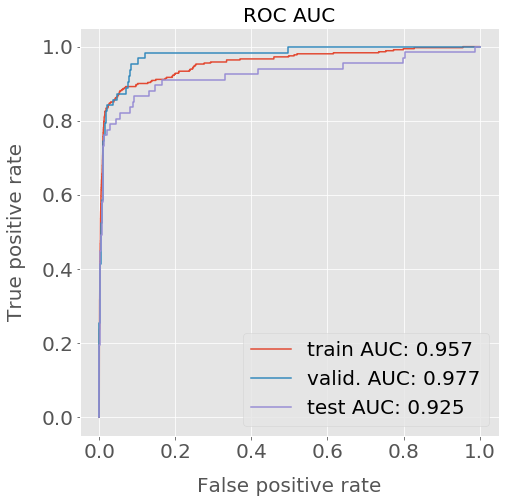

In [102]:
FONTSIZE = 20
plt.close('all')
fig, ax = plt.subplots(1, figsize=(7.5, 7.5))
ax.plot(train_fpr, train_tpr, label='train AUC: {0:.3f}'.format(train_auc))
ax.plot(val_fpr, val_tpr, label='valid. AUC: {0:.3f}'.format(val_auc))
ax.plot(test_fpr, test_tpr, label='test AUC: {0:.3f}'.format(test_auc))
ax.set_xlabel('False positive rate', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('True positive rate', fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc='best', fontsize=FONTSIZE)
_ = ax.set_title('ROC AUC', fontsize=FONTSIZE)

In [110]:
empirical_threshold = np.min(train_error[y_train == 1])


In [113]:

train_empirical_predict = (train_error > empirical_threshold).astype(int)
train_accuracy = np.mean(train_empirical_predict == y_train)

val_empirical_predict = (val_error > empirical_threshold).astype(int)
val_accuracy = np.mean(val_empirical_predict == y_val)

test_empirical_predict = (test_error > empirical_threshold).astype(int)
test_accuracy = np.mean(test_empirical_predict == y_test)

print("train accuracy: {0:.3f}".format(train_accuracy))
print("valid. accuracy: {0:.3f}".format(val_accuracy))
print("test accuracy: {0:.3f}".format(test_accuracy))


train accuracy: 0.046
valid. accuracy: 0.047
test accuracy: 0.048


In [117]:
train_confusion_df = pd.DataFrame({'predict': train_empirical_predict, 'truth': y_train})
confusion_matrix(y_train, train_empirical_predict)

array([[  9079, 196331],
       [     1,    361]])